In [1]:
!pip install joblib

In [4]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import re
import random

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras import layers, models
import tensorflow_datasets as tfds
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, ClassifierMixin

import warnings
warnings.filterwarnings('ignore')

drive_path = '/content/drive/MyDrive/Kuliah/Tugas Akhir/Final Project Shared Folder'
data_path = "Dataset/Data Versioning/"
model_path = "Model/ML Model/"
data_version = "Trained_App-4.csv"
base_url = "https://wwwn.cdc.gov/nchs/nhanes/search/datapage.aspx?CycleBeginYear=2017"
dataset_names = ['Demographics', 'Dietary', 'Examination', 'Laboratory', 'Questionnaire']

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
import joblib

In [6]:

df_raw = pd.read_csv(os.path.join(drive_path, data_path+data_version), index_col = 0)
try:
  df_raw = df_raw.set_index('SEQN', drop=True)
  df_raw = df_raw.drop(columns = "Unnamed: 0")
except:
  pass

df_raw.head()

,Quest22_SMQ890,Quest22_SMQ900,Quest21_SLD123,Quest21_SLQ3032,Dieta1_DR1TKCAL,Dieta1_DR1TPROT,Dieta1_DR1TCARB,Dieta1_DR1TSUGR,Dieta1_DR1TFIBE,Dieta1_DR1TTFAT,...,Dieta1_DR1TCALC,Quest19_VigorousActivity,Demog1_RIDAGEYR,Exami2_BMXWT,Exami2_BMXHT,Exami2_BMXBMI,Quest3_CDQ008,Exami1_SysPulse,Exami1_DiaPulse,Quest16_MCQ160B
SEQN,,,,,,,,,,,,,,,,,,,,,
93705.0,0.0,0.0,1,3,0,0,0,1,0,1,...,0,0,66.0,79.5,158.3,31.7,0.0,157.722370,69.961686,2.0
93708.0,0.0,0.0,1,2,0,0,0,0,2,1,...,0,0,66.0,53.5,150.2,23.7,0.0,139.094017,75.777778,2.0
93709.0,1.0,1.0,0,2,1,2,1,2,2,2,...,2,1,75.0,88.8,151.1,38.9,0.0,118.666667,66.666667,2.0
93711.0,0.0,0.0,1,2,3,3,3,3,3,3,...,3,1,56.0,62.1,170.6,21.3,0.0,101.333333,66.666667,2.0
93713.0,0.0,0.0,0,3,2,1,1,2,1,3,...,1,0,67.0,74.9,178.6,23.5,0.0,104.666667,72.000000,2.0


In [7]:
def get_categorical(df):
    categorical = []
    for col in df.columns.tolist():
        try:
            if len(df[col].unique().tolist()) < 20:
                categorical.append({
                    'desc': model_var[model_var['model_var_name'] ==  col]['desc'].values[0],
                    'column': col,
                    'possible_values': df[col].unique().tolist()}
                            )
        except Exception as error:
            if len(df[col].unique().tolist()) < 20:
                categorical.append({
                    'desc': None,
                    'column': col,
                    'possible_values': df[col].unique().tolist()})
            # print(f'{col} error: {error}')
    return categorical


In [8]:
from imblearn.over_sampling import SMOTENC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold

def prep_data_cross_validation(df, num_folds=5):
  X = df.copy().drop(columns=['Quest16_MCQ160B'])
  y = df['Quest16_MCQ160B']

  y = y.replace({2: 0})
  y = y.replace({9: 0})

  y = y.astype(int)

  categorical_summary = get_categorical(X)
  categorical_cols = [True if data_col in [col['column'] for col in categorical_summary] else False for data_col in X.columns.tolist()]

  kf = KFold(n_splits=num_folds, shuffle=True, random_state=37)

  for train_index, val_index in kf.split(X):
    X_train, X_val, y_train, y_val = X.iloc[train_index, :], X.iloc[val_index, :], y.iloc[train_index], y.iloc[val_index]

    # Instantiate the SMOTE oversampler
    smotenc = SMOTENC(
        categorical_features=categorical_cols,
        sampling_strategy='auto',
        random_state=37
      )

    # Apply SMOTE to generate synthetic samples
    X_resampled, y_resampled = smotenc.fit_resample(X_train, y_train)

    scaler = StandardScaler()
    X_resampled.iloc[:, 17:] = scaler.fit_transform(X_resampled.iloc[:, 17:])
    X_val.iloc[:, 17:] = scaler.transform(X_val.iloc[:, 17:])

    X_resampled = np.array(X_resampled).reshape(X_resampled.shape[0], X_resampled.shape[1], 1)
    X_val = np.array(X_val).reshape(X_val.shape[0], X_val.shape[1], 1)

    yield X_resampled, X_val, y_resampled, y_val


In [9]:
def get_categorical(df):
    categorical = []
    for col in df.columns.tolist():
        try:
            if len(df[col].unique().tolist()) < 20:
                categorical.append({
                    'desc': model_var[model_var['model_var_name'] ==  col]['desc'].values[0],
                    'column': col,
                    'possible_values': df[col].unique().tolist()}
                            )
        except Exception as error:
            if len(df[col].unique().tolist()) < 20:
                categorical.append({
                    'desc': None,
                    'column': col,
                    'possible_values': df[col].unique().tolist()})
            # print(f'{col} error: {error}')
    return categorical


In [33]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTENC, SMOTE

def prep_data_final(df):
  X = df.copy().drop(columns=['Quest16_MCQ160B'])
  y = df['Quest16_MCQ160B']

  y = y.replace({2: 0})
  y = y.replace({9: 0})

  y = y.astype(int)

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=43, shuffle=True, stratify=y)

  categorical_summary = get_categorical(X)
  categorical_cols = [True if data_col in [col['column'] for col in categorical_summary] else False for data_col in X.columns.tolist()]

  # Instantiate the SMOTE oversampler
  smotenc = SMOTENC(
      categorical_features=categorical_cols,
      sampling_strategy='auto',
      random_state=37
    )

  # Apply SMOTE to generate synthetic samples
  X_resampled, y_resampled = smotenc.fit_resample(X_train, y_train)

  scaler = StandardScaler()
  X_resampled.iloc[:, 16:] = scaler.fit_transform(X_resampled.iloc[:, 16:])
  joblib.dump(scaler, 'v2_standard_scaler.gz')
  X_test.iloc[:, 16:] = scaler.transform(X_test.iloc[:, 16:])

  X_resampled = np.array(X_resampled).reshape(X_resampled.shape[0], X_resampled.shape[1], 1)

  return X_resampled, X_test, y_resampled, y_test

X_train, X_test, y_train, y_test = prep_data_final(df_raw)
input_shape = X_train.shape[1:]

print(y_train.value_counts())

Quest16_MCQ160B
0    4294
1    4294
Name: count, dtype: int64


In [34]:
print(y_test.value_counts())

Quest16_MCQ160B
0    1074
1      40
Name: count, dtype: int64


In [35]:
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

class MetricsCallback(tf.keras.callbacks.Callback):
    def __init__(self, validation_data=()):
        super(MetricsCallback, self).__init__()
        self.validation_data = validation_data
        self.logs = {}

    def on_epoch_end(self, epoch, logs={}):
        if not self.validation_data:
            raise RuntimeError("Requires validation_data.")

        X_val, y_val = self.validation_data
        y_proba = self.model.predict(X_val, verbose=0)

        # Convert one-hot encoded labels to class labels
        y_pred = np.argmax(y_proba, axis=1)

        # Compute Metrics score
        f1score = f1_score(y_val, y_pred, average='weighted')
        roc_auc = roc_auc_score(y_val, y_pred, average='weighted')

        # Add Metrics score to logs
        self.logs['roc_auc'] = roc_auc
        self.logs['f1score'] = f1score

        # Calculate ROC curve
        fpr, tpr, thresholds = roc_curve(y_val, y_proba[:, 1])

        # Compute the optimal threshold by maximizing the Youden's J statistic
        J = tpr - fpr
        optimal_idx = np.argmax(J)
        optimal_threshold = thresholds[optimal_idx]

        # Alternatively, you can minimize the distance to the top-left corner (0,1)
        distances = np.sqrt(fpr**2 + (1-tpr)**2)
        optimal_idx = np.argmin(distances)
        optimal_threshold = thresholds[optimal_idx]

        y_pred_optimal_threshold = [1 if prob[1] >= optimal_threshold else 0 for prob in y_proba]

        # Compute Metrics score
        f1score_optimal_threshold = f1_score(y_val, y_pred_optimal_threshold, average='weighted')
        roc_auc_optimal_threshold = roc_auc_score(y_val, y_pred_optimal_threshold, average='weighted')
        accuracy_optimal_threshold = accuracy_score(y_val, y_pred_optimal_threshold)

        self.logs['roc_auc_optimal_threshold'] = roc_auc_optimal_threshold
        self.logs['f1score_optimal_threshold'] = f1score_optimal_threshold
        self.logs['accuracy_optimal_threshold'] = accuracy_optimal_threshold

In [52]:

def build_model():
  model = models.Sequential(
      [
        tf.keras.layers.Conv1D(filters=32, kernel_size=6, activation=tf.nn.tanh, input_shape=(input_shape)),
        tf.keras.layers.Conv1D(filters=4, kernel_size=2, activation=tf.nn.tanh),
        tf.keras.layers.LSTM(16, activation=tf.nn.sigmoid, return_sequences=True),
        tf.keras.layers.LSTM(32, activation=tf.nn.tanh, return_sequences=True),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation=tf.nn.sigmoid, kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        tf.keras.layers.Dense(64, activation=tf.nn.tanh, kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        tf.keras.layers.Dense(2, activation=tf.nn.softmax)
    ]
  )

  # Compile the model
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0007),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
  )

  return model

In [54]:
tf.random.set_seed(37)
random.seed(37)

loss = []
accuracy = []
f1score = []
auc = []

X_train, X_test, y_train, y_test = prep_data_final(df_raw)

model = build_model()
metrics_callback = MetricsCallback(validation_data=(X_test, y_test))

history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=30, callbacks=[metrics_callback])

_loss, _accuracy = model.evaluate(X_test, y_test, verbose=0)
loss.append(_loss)
accuracy.append(_accuracy)
f1score.append(metrics_callback.logs.get('f1score'))
auc.append(metrics_callback.logs.get('roc_auc'))

print()
model.summary()

Epoch 1/30
269/269 [==============================] - 13s 32ms/step - loss: 0.7801 - accuracy: 0.5509 - val_loss: 0.5984 - val_accuracy: 0.7217
Epoch 2/30
269/269 [==============================] - 5s 20ms/step - loss: 0.6801 - accuracy: 0.6422 - val_loss: 0.7742 - val_accuracy: 0.5081
Epoch 3/30
269/269 [==============================] - 6s 22ms/step - loss: 0.6000 - accuracy: 0.7156 - val_loss: 0.5031 - val_accuracy: 0.7810
Epoch 4/30
269/269 [==============================] - 7s 25ms/step - loss: 0.5151 - accuracy: 0.7817 - val_loss: 0.6148 - val_accuracy: 0.7047
Epoch 5/30
269/269 [==============================] - 5s 19ms/step - loss: 0.4913 - accuracy: 0.7905 - val_loss: 0.5003 - val_accuracy: 0.7442
Epoch 6/30
269/269 [==============================] - 7s 27ms/step - loss: 0.4781 - accuracy: 0.7961 - val_loss: 0.5385 - val_accuracy: 0.7334
Epoch 7/30
269/269 [==============================] - 5s 20ms/step - loss: 0.4707 - accuracy: 0.7997 - val_loss: 0.4073 - val_accuracy: 0.799

In [55]:
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, roc_auc_score

# Evaluate Model

proba = model.predict(X_test)
preds = np.argmax(proba, axis=1)

print("Accuracy: " + str(accuracy_score(y_test, preds)*100) + "%")
print("F1 Score: " + str(f1_score(y_test, preds, average='weighted')*100) + "%")
print("AUC: " + str(roc_auc_score(y_test, preds, average='weighted')*100) + "%")

print(confusion_matrix(y_test, preds))

35/35 [==============================] - 0s 6ms/step
Accuracy: 83.12387791741472%
F1 Score: 87.84610346744253%
AUC: 58.75465549348231%
[[913 161]
 [ 27  13]]


In [56]:
import numpy as np
from sklearn.metrics import roc_curve, roc_auc_score

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, model.predict(X_test)[:, 1])

# Compute the optimal threshold by maximizing the Youden's J statistic
J = tpr - fpr
optimal_idx = np.argmax(J)
optimal_threshold = thresholds[optimal_idx]

# Alternatively, you can minimize the distance to the top-left corner (0,1)
distances = np.sqrt(fpr**2 + (1-tpr)**2)
optimal_idx = np.argmin(distances)
optimal_threshold = thresholds[optimal_idx]

print(f"Optimal threshold: {optimal_threshold}")

35/35 [==============================] - 0s 6ms/step
Optimal threshold: 0.039993688464164734


In [57]:
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, roc_auc_score

# Evaluate Model

proba = model.predict(X_test)
preds = [1 if prob >= optimal_threshold else 0 for prob in proba[:, 1]]

print("Accuracy: " + str(accuracy_score(y_test, preds)*100) + "%")
print("F1 Score: " + str(f1_score(y_test, preds, average='weighted')*100) + "%")
print("AUC: " + str(roc_auc_score(y_test, preds, average='weighted')*100) + "%")

print(confusion_matrix(y_test, preds))

35/35 [==============================] - 0s 8ms/step
Accuracy: 58.43806104129264%
F1 Score: 70.64090155041949%
AUC: 66.41061452513968%
[[621 453]
 [ 10  30]]


In [59]:
from sklearn.metrics import classification_report

print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.98      0.58      0.73      1074
           1       0.06      0.75      0.11        40

    accuracy                           0.58      1114
   macro avg       0.52      0.66      0.42      1114
weighted avg       0.95      0.58      0.71      1114



# Summarize Model

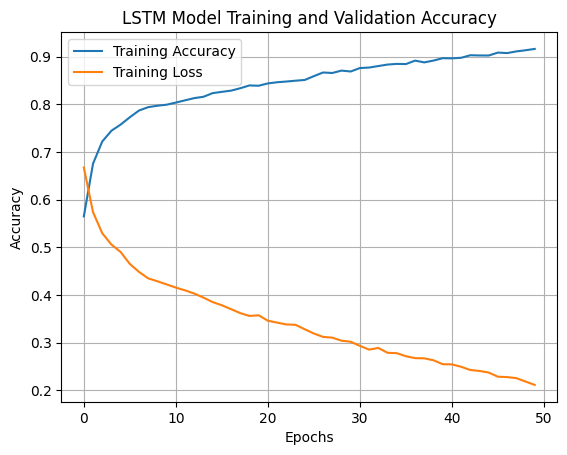

In [46]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['loss'], label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('LSTM Model Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Save Model

In [ ]:
model.save('model_cnn_proper_apps_v2.h5', save_format='h5')

In [ ]:
var_mapping_path = 'Dataset/Variable Mapping V3.xlsx'

var_mapping = pd.read_excel(os.path.join(drive_path, var_mapping_path))
var_mapping['group'] = var_mapping['group'].replace({'Dieta2': 'Dieta1'})
var_mapping['model_var_name'] = var_mapping['group'] + "_" + var_mapping['variable']

model_var = pd.DataFrame({'model_var_name': df_raw.columns.tolist()})

model_var = pd.merge(model_var, var_mapping, left_on=model_var['model_var_name'].str.lower(), right_on=var_mapping['model_var_name'].str.lower(), how='outer', indicator=True).query('_merge!="right_only"')

# To Check if all variable is tagged
# model_var[model_var['_merge'] == "left_only"]

model_var = model_var[['model_var_name_x', 'lifestyle', 'desc']].rename(columns={'model_var_name_x': 'model_var_name'}).drop_duplicates().reset_index(drop=True)

model_var

,model_var_name,lifestyle,desc
0,Quest22_SMQ890,False,Ever Smoked A Cigar Even 1 Time?
1,Quest22_SMQ900,False,Ever Used An E-Cigarette?
2,Quest21_SLQ300,True,Usual Sleep Time On Weekdays Or \nWorkdays
3,Quest21_SLQ330,True,Usual Wake Time On Weekends
4,Quest21_SLD012,True,Sleep Hours - Weekdays Or \nWorkdays
5,Dieta1_DR1TKCAL,True,Energy (Kcal)
6,Dieta1_DR1TPROT,True,Protein (Gm)
7,Dieta1_DR1TCARB,True,Carbohydrate (Gm)
8,Dieta1_DR1TSUGR,True,Total Sugars (Gm)
9,Dieta1_DR1TFIBE,True,Dietary Fiber (Gm)


In [ ]:
model_var.loc[model_var['lifestyle'].isna(), 'lifestyle'] = True
model_var.loc[model_var['desc'].isna(), 'desc'] = 'Minutes of Vigorous Activity'

In [ ]:
model_var[model_var['lifestyle'] == True].shape

(16, 3)

In [ ]:
model_var.set_index('model_var_name').loc[[col for col in sorted(df_raw.columns.tolist()) if "Dieta" in col]]

,lifestyle,desc
model_var_name,,
Dieta1_DR1TCALC,True,Calcium (Mg)
Dieta1_DR1TCARB,True,Carbohydrate (Gm)
Dieta1_DR1TCHOL,True,Cholesterol (Mg)
Dieta1_DR1TFIBE,True,Dietary Fiber (Gm)
Dieta1_DR1TKCAL,True,Energy (Kcal)
Dieta1_DR1TMFAT,True,Total Monounsaturated Fatty Acids (Gm)
Dieta1_DR1TPFAT,True,Total Polyunsaturated Fatty Acids (Gm)
Dieta1_DR1TPROT,True,Protein (Gm)
Dieta1_DR1TSFAT,True,Total Saturated Fatty Acids (Gm)


In [ ]:
df_raw['Quest3_CDQ008'].value_counts()

Quest3_CDQ008
9.0    4437
2.0     857
1.0     275
Name: count, dtype: int64

In [ ]:
import json

# generate lifestyle description
json_obj = {}
for col, desc in model_var[model_var['lifestyle']==True][['model_var_name', 'desc']].values:
    json_obj[col]=desc

with open('v1_lifestyle_description.json', 'w') as json_file:
    json.dump(json_obj, json_file)

# generate columns order
column_order = {'lifestyle': {}, 'characteristic': {}}
sampling = df_raw.sample(n=1, axis=0)

for index, key in enumerate(sampling.columns.tolist()):
    if index < model_var[model_var['lifestyle']==True].shape[0]:
        column_order['lifestyle'][key] = index
    else:
        column_order['characteristic'][key] = index

with open('v1_columns_order.json', 'w') as json_file:
    json.dump(column_order, json_file)

In [ ]:
list(df_raw[df_raw['Quest3_CDQ008'] == 1].sample(1).values)

[array([  2. ,   2. ,   2. ,   2. ,   3. ,   2. ,   1. ,   2. ,   2. ,
          1. ,   2. ,   2. ,   2. ,   2. ,   2. ,   2. ,   0. ,  66. ,
         94.6, 161.8,  36.1,   1. ,  78. ,  78. ,   2. ])]

In [ ]:
list(df_raw[df_raw['Quest3_CDQ008'] == 1].sample(1))

['Quest22_SMQ890',
 'Quest22_SMQ900',
 'Quest21_SLQ300',
 'Quest21_SLQ330',
 'Quest21_SLD012',
 'Dieta1_DR1TKCAL',
 'Dieta1_DR1TPROT',
 'Dieta1_DR1TCARB',
 'Dieta1_DR1TSUGR',
 'Dieta1_DR1TFIBE',
 'Dieta1_DR1TTFAT',
 'Dieta1_DR1TSFAT',
 'Dieta1_DR1TMFAT',
 'Dieta1_DR1TPFAT',
 'Dieta1_DR1TCHOL',
 'Dieta1_DR1TCALC',
 'Quest19_VigorousActivity',
 'Demog1_RIDAGEYR',
 'Exami2_BMXWT',
 'Exami2_BMXHT',
 'Exami2_BMXBMI',
 'Quest3_CDQ008',
 'Exami1_SysPulse',
 'Exami1_DiaPulse',
 'Quest16_MCQ160B']